In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [3]:
base_dir = "Rice Leaf"

In [4]:
img_height = 224
img_width = 224
channels = 3
batch_size = 128

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

class_names = df.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in df:
    for label in labels.numpy():  
        class_counts[class_names[int(label)]] += 1  

print(class_counts)

Found 6265 files belonging to 6 classes.
{'blast': 1033, 'blight': 1063, 'brownspot': 1034, 'healthy': 1045, 'hispa': 1045, 'tungro': 1045}


In [6]:
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    validation_split=0.2,  
    subset="training",  
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True 
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    validation_split=0.2, 
    subset="validation",  
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False  
)

train_size = int(len(train_val_ds) * 0.8)  
val_size = int(len(train_val_ds) * 0.1) 
test_size = len(train_val_ds) - train_size - val_size  

train_ds = train_val_ds.take(train_size)  
val_ds = train_val_ds.skip(train_size).take(val_size)  
test_ds = train_val_ds.skip(train_size + val_size).take(test_size)  


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Found 6265 files belonging to 6 classes.
Using 5012 files for training.
Found 6265 files belonging to 6 classes.
Using 1253 files for validation.
Train samples: 32
Validation samples: 4
Test samples: 4


In [7]:
labels = []
for _, y in train_ds:
    label_indices = np.argmax(y.numpy(), axis=1)
    labels.extend(label_indices)
labels = np.array(labels)

unique_classes = np.unique(labels)

class_weights = class_weight.compute_class_weight(
    'balanced',                        
    classes=unique_classes,            
    y=labels                          
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: np.float64(0.9922480620155039), 1: np.float64(0.9794356767097083), 2: np.float64(1.0083702609551946), 3: np.float64(1.0054000981836033), 4: np.float64(1.003921568627451), 5: np.float64(1.011358024691358)}


In [8]:
data_dir = base_dir  
class_names = sorted(os.listdir(data_dir))
print(class_names)

['blast', 'blight', 'brownspot', 'healthy', 'hispa', 'tungro']


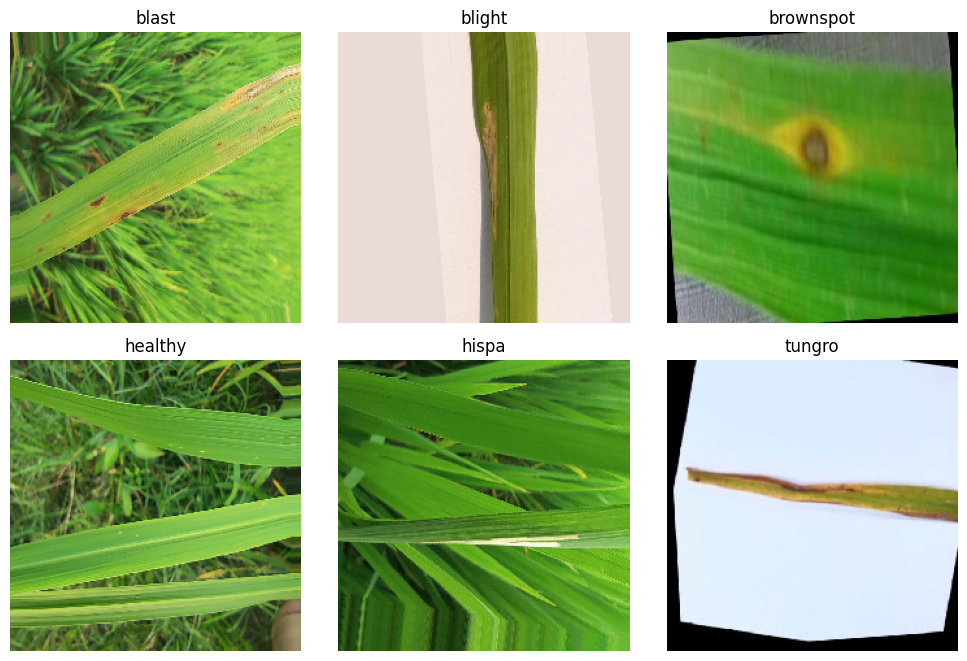

In [9]:
from tensorflow.keras.preprocessing import image
import random
class_names = os.listdir(data_dir)

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):  
        
        image_files = os.listdir(class_dir)
        
        if image_files:
           
            img_path = os.path.join(class_dir, random.choice(image_files))         
            img = image.load_img(img_path, target_size=(224, 224))
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

plt.tight_layout()
plt.show()

**Model Building**

In [10]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer = "he_uniform", padding = "valid", input_shape=(img_width, img_height, channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax', kernel_initializer="glorot_uniform")
    
    ])
model.summary()

c:\Users\My ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 23,336,134 (89.02 MB)

 Trainable params: 23,333,638 (89.01 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self, patience=10):
        super(CustomCallback, self).__init__()
        self.patience = patience
        self.counter = 0
        self.best_val_acc = float('-inf')  
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.93 and logs['val_accuracy'] > 0.93:
            self.model.stop_training = True
            print("\n Pelatihan berhenti karena akurasi dan val acc sudah 100%.")
        elif logs['val_accuracy'] > self.best_val_acc:
            self.best_val_acc = logs['val_accuracy']
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.model.stop_training = True
                print("\n Pelatihan berhenti karena val acc tidak meningkat dalam {} epoch terakhir.".format(self.patience))

callbacks = CustomCallback(patience=50)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [13]:
initial_epochs = 100
history = model.fit(train_ds,
                    callbacks = [callbacks, lr_scheduler],
                    class_weight=class_weight_dict,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.3708 - loss: 1.6031 - val_accuracy: 0.3379 - val_loss: 3.8639 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5688 - loss: 1.1388 - val_accuracy: 0.4336 - val_loss: 1.4002 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6298 - loss: 0.9445 - val_accuracy: 0.5469 - val_loss: 0.9953 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7034 - loss: 0.7614 - val_accuracy: 0.5508 - val_loss: 0.9115 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.7515 - loss: 0.6534 - val_accuracy: 0.7031 - val_loss: 0.7807 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7942 - loss: 0.5504 - val_accuracy: 0.7266 - val_loss: 0.6548 - learning_rate: 1.0000e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 

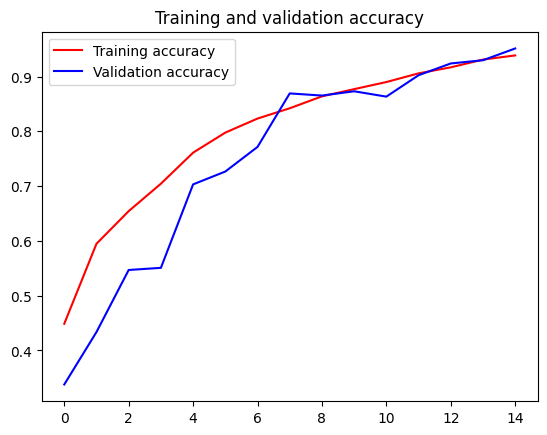

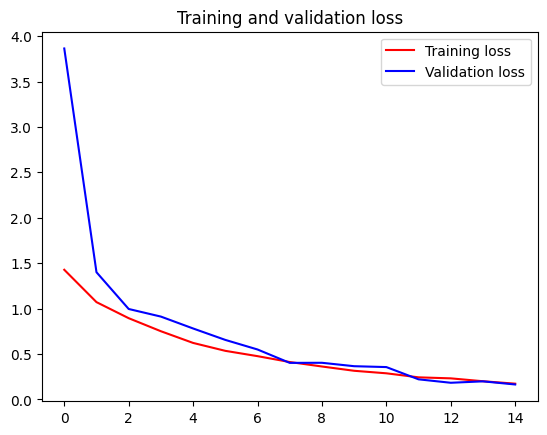

<Figure size 640x480 with 0 Axes>

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


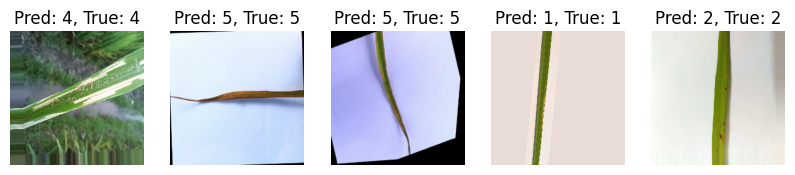

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        26
           1       1.00      1.00      1.00        22
           2       0.88      0.96      0.92        24
           3       0.82      0.95      0.88        19
           4       1.00      0.95      0.97        19
           5       1.00      0.94      0.97        18

    accuracy                           0.94       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.94      0.94      0.94       128



In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(test_ds))

predictions = model.predict(sample_images)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(sample_labels.numpy(), axis=1)

num_images = 5  

plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title(f"Pred: {predicted_labels[i]}, True: {true_labels[i]}")
    plt.axis("off")
plt.show()

from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

In [16]:
model.save('SmartPaddy_final_.h5')  

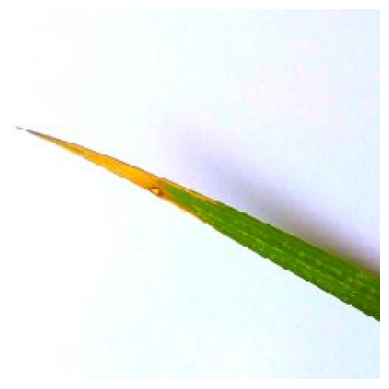

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Predicted Class: blast
Probability: 0.82


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = r'IMG  (131).jpg'

model = load_model('SmartPaddy_final_.h5')

img = image.load_img(img_path, target_size=(img_width, img_height))

plt.imshow(img)
plt.axis('off')  
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

classes = model.predict(images)

class_names = ['blast', 'blight', 'brown spot', 'healthy', 'hispa', 'tungro']

predicted_class = class_names[np.argmax(classes)]  
predicted_prob = np.max(classes)  

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.2f}")


**Transfer Learning**

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('Model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\MYASUS~1\AppData\Local\Temp\tmpc8z2ntai\assets


INFO:tensorflow:Assets written to: C:\Users\MYASUS~1\AppData\Local\Temp\tmpc8z2ntai\assets


Saved artifact at 'C:\Users\MYASUS~1\AppData\Local\Temp\tmpc8z2ntai'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2815143652304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143650192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143652496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143651536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143651152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143648848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143650960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143653648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143653456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2815143650384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  281